In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from joblib import Parallel, delayed
import xgboost as xgb
import copy
from xgboost.sklearn import XGBRegressor
import os
from sklearn.linear_model import LinearRegression
import warnings
import joblib
from sklearn.model_selection import train_test_split, KFold
import lightgbm as lgb
import datatable as dt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
warnings.filterwarnings(action='ignore', category=UserWarning)
# import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
import os
os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses


In [2]:
stock_id = 0
dataType = 'train'
pd.read_parquet(f'../data/book_{dataType}.parquet/stock_id={stock_id}/')

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


# Train: https://www.kaggle.com/yus002/realized-volatility-prediction-lgbm-train

# Reference: https://www.kaggle.com/mayunnan/realized-volatility-prediction-code-template

In [3]:
def my_metrics(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
def rmspe(y_true, y_pred):  # f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
    output = my_metrics(y_true, y_pred)
    return 'rmspe', output, False
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def get_stock_stat(stock_id : int, dataType = 'train'):   
    book_train_subset = pd.read_parquet(f'../data/book_{dataType}.parquet/stock_id={stock_id}/')
    book_train_subset.sort_values(by=['time_id', 'seconds_in_bucket'])

    book_train_subset['bas'] = (book_train_subset[['ask_price1', 'ask_price2']].min(axis = 1)
                                / book_train_subset[['bid_price1', 'bid_price2']].max(axis = 1)
                                - 1)                               
    book_train_subset['wap'] = (book_train_subset['bid_price1'] * book_train_subset['ask_size1'] +
                            book_train_subset['ask_price1'] * book_train_subset['bid_size1']) / (
                            book_train_subset['bid_size1']+ book_train_subset['ask_size1'])
    book_train_subset['log_return'] = (book_train_subset.groupby(by = ['time_id'])['wap'].
                                       apply(log_return).
                                       reset_index(drop = True).
                                       fillna(0)
                                      )
    stock_stat = pd.merge(
        book_train_subset.groupby(by = ['time_id'])['log_return'].agg(realized_volatility).reset_index(),
        book_train_subset.groupby(by = ['time_id'], as_index = False)['bas'].mean(),
        on = ['time_id'],
        how = 'left'
    )
    stock_stat['stock_id'] = stock_id
    return stock_stat
def get_dataSet(stock_ids : list, dataType = 'train'):
    stock_stat = Parallel(n_jobs=-1)(
        delayed(get_stock_stat)(stock_id, dataType) 
        for stock_id in stock_ids
    )
    stock_stat_df = pd.concat(stock_stat, ignore_index = True)
    return stock_stat_df

In [4]:
stock_id = 0
book_train_subset = pd.read_parquet(f'../data/book_train.parquet/stock_id={stock_id}/')
book_train_subset.sort_values(by=['time_id', 'seconds_in_bucket'])

book_train_subset['bas'] = (book_train_subset[['ask_price1', 'ask_price2']].min(axis = 1)
                            / book_train_subset[['bid_price1', 'bid_price2']].max(axis = 1)
                            - 1)                               
book_train_subset['wap'] = (book_train_subset['bid_price1'] * book_train_subset['ask_size1'] +
                        book_train_subset['ask_price1'] * book_train_subset['bid_size1']) / (
                        book_train_subset['bid_size1']+ book_train_subset['ask_size1'])
book_train_subset['log_return'] = (book_train_subset.groupby(by = ['time_id'])['wap'].
                                   apply(log_return).
                                   reset_index(drop = True).
                                   fillna(0)
                                  )

In [5]:
book_train_subset['log_return']

0         0.000000
1         0.000014
2         0.000000
3        -0.000005
4         0.000000
            ...   
917548    0.000434
917549    0.000001
917550    0.000000
917551    0.000001
917552    0.000000
Name: log_return, Length: 917553, dtype: float32

In [8]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))
realized_volatility(book_train_subset.loc[(book_train_subset.time_id == 5) ,'log_return' ])

0.004499369

In [60]:
# book_train_subset.loc[(book_train_subset.time_id == 11) ,'log_return' ]
import seaborn as sns 
sns.distplot(book_train_subset['log_return'])

In [42]:
ts.mean()

7.588485339101379e-06

In [80]:
import matplotlib.pyplot as plt 
from arch.__future__ import reindexing
np.seterr(all='ignore')
ts = (book_train_subset.loc[(book_train_subset.time_id == 11) ,'log_return' ]).astype('double')
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(ts**2)
# ts
from arch import arch_model
# split into train/test
# train, test = ts[:-n_test], ts[-n_test:]
train = ts

model = arch_model((train), mean='Constant', vol='ARCH', p=1,rescale = False)
model_fit = model.fit(disp='off', show_warning=False)
# forecast the test set
yhat = model_fit.forecast(horizon=600)
16*np.sqrt(yhat.variance.values[-1, :].mean())
# plot the actual variance
# var = test.reset_index(drop = True)
# plt.plot(var*1000)
# plot forecast variance
# plt.plot(yhat.variance.values[-1, :])
# plt.show()

0.0013620385184781546

In [182]:
from tqdm import tqdm
def arch_vol(ts):
    ts = ts.astype('double')
    model = arch_model(ts, mean='Constant', vol='ARCH', p=1,rescale = False)
    model_fit = model.fit(disp='off', show_warning=False)
    # forecast the test set
    yhat = model_fit.forecast(horizon=600)
    return 16*np.sqrt(yhat.variance.values[-1, :].mean())  
#     np.sqrt(ts.shape[0]-) return np.sqrt(yhat.variance.values[-1, :].sum())
def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    a = (df_book_data['bid_price1'] * df_book_data['ask_size1'] +
                                df_book_data['ask_price1'] * df_book_data['bid_size1']) / (
                                       df_book_data['bid_size1']+ df_book_data['ask_size1'])

    b = (df_book_data['bid_price2'] * df_book_data['ask_size2'] +
                                df_book_data['ask_price2'] * df_book_data['bid_size2']) / (
                                       df_book_data['bid_size2']+ df_book_data['ask_size2'])
    df_book_data['wap'] = (a+b)/2
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(arch_vol)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in tqdm(list_file):
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

In [193]:
arch_vol((book_train_subset.loc[(book_train_subset.time_id == 5) ,'log_return' ]))
# book_train_subset.groupby(['time_id'])['log_return'].agg(arch_vol)

0.0041399115297475215

In [199]:
# np.sqrt(302)
train['row_id'] = train[['stock_id', 'time_id']].astype('str').agg('-'.join, axis=1)

In [287]:
df = train.merge(final_pred2,on = 'row_id')

In [203]:
rmspe

,target_x,target_y
target_x,1.0000,-0.0004
target_y,-0.0004,1.0000


In [55]:
# model_fit.variance
# (yhat.compute_variance)
# 16*np.sqrt(yhat.variance.values[-1, :].mean())
from arch.univariate import ConstantMean,GARCH, Normal
# from arch import 
ts = (book_train_subset.loc[(book_train_subset.time_id == 5) ,'log_return' ]).astype('double')

am = ConstantMean(ts)
am.volatility = GARCH(1, 0, 1)
am.distribution = Normal()
res = am.fit()
yhat = res.forecast(horizon=600)
# np.sqrt(sum(model_fit.conditional_volatility))
# yhat.variance.values[]

Iteration:      1,   Func. Count:      6,   Neg. LLF: -2073.6969189037263
Iteration:      2,   Func. Count:     22,   Neg. LLF: -2073.855263911387
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -2073.855263723061
            Iterations: 2
            Function evaluations: 22
            Gradient evaluations: 2


C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.698e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


In [310]:
( book_train_subset.loc[book_train_subset['seconds_in_bucket']>=540].groupby(['time_id']).apply(len)>0) .all()

True

In [ ]:
# import seaborn as sns 
# import matplotlib.pyplot as plt
# plt.plot(book_train_subset.loc[book_train_subset.time_id == 72, 'bas'])
# book_train_subset.time_id.unique()[1:8]
# (book_train_subset['log_return']).mean()

In [ ]:
#keep_stock_id = 1
keep_stock_id = 0


In [ ]:
# dt.fread('../input/mytrain/X_stock_id_cat.csv').to_pandas()

In [ ]:
# train -------------------------
if keep_stock_id:
    td = dt.fread('../input/mytrain/X_stock_id_cat.csv')
    X = td.to_pandas()
    del td
else: 
    X = pd.read_csv("../input/mytrain/X.csv")
y = pd.read_csv("../input/mytrain/y.csv")
# to_test ----------------------------------------------------
test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
test_stock_stat_df = get_dataSet(stock_ids = test['stock_id'].unique(), dataType = 'test')
test_dataSet = pd.merge(test, test_stock_stat_df, on = ['stock_id', 'time_id'], how = 'left')
test_dataSet = test_dataSet
final_pred1 = test_dataSet[['row_id']]
to_test = test_dataSet.drop(['row_id'], axis = 1).fillna(0)
if keep_stock_id:
    train = pd.read_csv("../input/optiver-realized-volatility-prediction/train.csv")
    cols = [f'stock_id_{c}' for c in list(set(train.stock_id))]
    to_test[cols] = pd.DataFrame(np.stack([(to_test.stock_id == c).astype('int') for c in list(set(train.stock_id))]).T, columns = cols)
    to_test = to_test.drop("stock_id", axis = 1)
# else:
#     to_test = to_test.drop("stock_id", axis = 1)
#     X = X.drop("stock_id", axis = 1)

# Load in models

In [ ]:
output = []
if keep_stock_id:
    for filepath in glob.iglob('../input/629rvp-train/*.pkl'):
        model = joblib.load(filepath)
        y_pred = model.predict(to_test, num_iteration = model.best_iteration_)
        output.append(y_pred)
        del model
        del y_pred
else:
    for filepath in glob.iglob('../input/629rvpstock-id-as-continous/*.pkl'):
        model = joblib.load(filepath)
        y_pred = model.predict(to_test, num_iteration = model.best_iteration_)
        output.append(y_pred)
        del model
        del y_pred
y_pred = sum(output) / len(output)

In [ ]:
final_pred1 = final_pred1.assign(target = y_pred)

# final_pred2
train = pd.read_csv('../data/train.csv')
train[]

# Best Naive baseline 0.29082
# Reference: https://www.kaggle.com/pratibha9/a-quick-model

In [278]:
def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    a = (df_book_data['bid_price1'] * df_book_data['ask_size1'] +
                                df_book_data['ask_price1'] * df_book_data['bid_size1']) / (
                                       df_book_data['bid_size1']+ df_book_data['ask_size1'])

    b = (df_book_data['bid_price2'] * df_book_data['ask_size2'] +
                                df_book_data['ask_price2'] * df_book_data['bid_size2']) / (
                                       df_book_data['bid_size2']+ df_book_data['ask_size2'])
    df_book_data['wap'] = (a+b)/2
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    df_realized_vol_per_stock['len'] = df_book_data.groupby(['time_id']).apply(len).values
    return df_realized_vol_per_stock[['row_id',prediction_column_name,'len']]
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in tqdm(list_file):
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

In [280]:
list_order_book_file_train = glob.glob('../data/book_train.parquet/*')
final_pred3 = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                           prediction_column_name='target')
# final_pred2

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [05:27<00:00,  2.93s/it]


In [281]:
# realized_volatility_per_time_id(list_order_book_file_train[0],'target')

In [296]:
# train
np.log(df[['target_x','len']]).corr()

,target_x,len
target_x,1.000000,-0.066996
len,-0.066996,1.000000


In [284]:
final_pred3.to_csv('preds_naive.csv',index = False)

In [288]:
df = df.merge(final_pred3,on = 'row_id')
df['tes'] = df['target_y']*np.sqrt(df['len'])

In [291]:
df

,stock_id,time_id,target_x,row_id,target_y,target,len,tes
0,0,5,0.004136,0-5,0.003793,0.004115,301,0.065806
1,0,11,0.001445,0-11,0.001438,0.001268,199,0.020281
2,0,16,0.002168,0-16,0.003178,0.002719,187,0.043456
3,0,31,0.002195,0-31,0.003836,0.002625,119,0.041844
4,0,62,0.001747,0-62,0.002299,0.001901,175,0.030410
...,...,...,...,...,...,...,...,...
428927,126,32751,0.003461,126-32751,0.003037,0.003338,309,0.053392
428928,126,32753,0.003113,126-32753,0.003578,0.003347,222,0.053305
428929,126,32758,0.004070,126-32758,0.003701,0.003695,255,0.059093
428930,126,32763,0.003357,126-32763,0.002707,0.003375,398,0.054004


In [189]:
final_pred2.to_csv('preds_arch.csv',index = False)

In [204]:
def rmse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss


In [302]:
# rmse(df['target_x'],df['target_y'])
df['sqrt_len']=np.sqrt(df['len'])
df.groupby(['stock_id']).get_group(0)[['target_x','len','target']].corr()

,target_x,len,target
target_x,1.000000,0.301548,0.822418
len,0.301548,1.000000,0.219787
target,0.822418,0.219787,1.000000


In [260]:
(df[['target_x','len','target']]).corr()

,target_x,len,target
target_x,1.000000,-0.288174,0.866859
len,-0.288174,1.000000,-0.231883
target,0.866859,-0.231883,1.000000


In [92]:
#
final_pred2['time_id'] = final_pred2['row_id'].apply(lambda x : x.split('-')[1])
final_pred2['stock_id'] = final_pred2['row_id'].apply(lambda x : x.split('-')[0])

final_pred2

,row_id,target,time_id,stock_id
0,0-5,0.004115,5,0
1,0-11,0.001268,11,0
2,0-16,0.002719,16,0
3,0-31,0.002625,31,0
4,0-62,0.001901,62,0
...,...,...,...,...
3825,99-32751,0.001555,32751,99
3826,99-32753,0.001774,32753,99
3827,99-32758,0.001583,32758,99
3828,99-32763,0.002299,32763,99


In [ ]:
output = final_pred1.merge(final_pred2, on = "row_id", how = "outer").fillna(0)
# x: my pred, y: naive
my_pred_weight = 0.5
output["target"] = output.target_x * my_pred_weight + output.target_y * (1 - my_pred_weight)
output = output[["row_id", "target"]]
output.to_csv('submission.csv',index = False)
print(output)

In [ ]:
# get_stock_stat(0)
# plt.plot((book_train_subset.time_id.unique()))
# plt.plot(np.log(book_train_subset['wap']))

In [15]:
train = pd.read_csv('../data/train.csv')

In [22]:
tr = train.loc[train.stock_id == 0][['time_id','target']]
import matplotlib.pyplot as plt

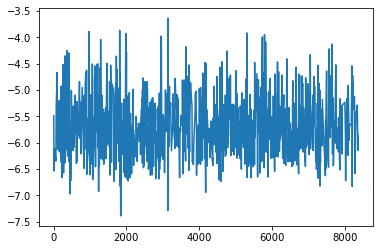

In [30]:
plt.plot((tr.time_id[:1000]), np.log(tr.target[:1000]))

C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


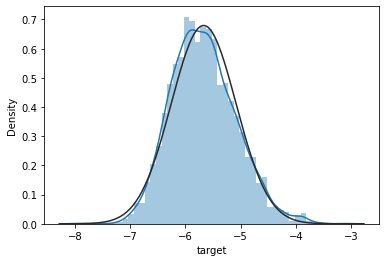

In [78]:
from scipy.stats import norm
tr = train.loc[train.stock_id == 16][['time_id','target']]
sns.distplot(np.log(tr.target),fit = norm)

In [57]:
def normality_test(data):
    from scipy.stats import normaltest
    mu, std = norm.fit(data)
    stat, p = normaltest((data-mu)/std)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [67]:
tr = train.loc[train.stock_id == 6][['time_id','target']]
normality_test(np.log(tr.target))
# mu, std = norm.fit(np.log(tr.target))
# mu, std

Statistics=9.444, p=0.009
Sample does not look Gaussian (reject H0)


(112,)

In [98]:
final_pred2.sort_values(['stock_id', 'time_id'], ascending = (True,True))

,row_id,target,time_id,stock_id
103,0-1000,0.002205,1000,0
1185,0-10000,0.002476,10000,0
1186,0-10005,0.008702,10005,0
1187,0-10017,0.011859,10017,0
1188,0-10030,0.002571,10030,0
...,...,...,...,...
1180,99-9972,0.001711,9972,99
1181,99-9973,0.010117,9973,99
1182,99-9976,0.004754,9976,99
1183,99-9988,0.001345,9988,99
